In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Empathic library imports
import empathicTD as empTD
import offTD as offTD
from policies import Policy, LeftRightPolicy
from models import Model
from utils import mom

In [2]:
%matplotlib notebook

In [3]:
class comparatorTD(object):
    '''
        This class compute and plot the offTD and empathicTD for one model.
        It makes the notebook clearer.
    '''
    
    def __init__(self, model):
        self.model = model
        
    def run(self, T, N, verbose = True):   
        '''
            Run the offTD and the empTD on the model
            Compute also the deterministic descent
                         the MOM estimator (to remove outlier)
                         the theta optimal
        '''
        
        self.theta_emp = empTD.run(model, T, N, verbose = verbose)  
        self.theta_off = offTD.run(model, T, N, verbose = verbose)    

        self.theta_off_opt = offTD.optimal_run(model, T)
        self.theta_emp_opt = empTD.optimal_run(model, T) 

        self.theta_emp_mom = mom(np.swapaxes(self.theta_emp, 0, 1))
        self.theta_off_mom = mom(np.swapaxes(self.theta_off, 0, 1))     
        
        self.theta_final = empTD.optimal(self.model)   
        
        
        
    def plot_theta(self, i = 0, mom = True, particles = True, optimal = True, figure = True, ylim = None):
        '''
            Plot one dimension (i) of theta across the particles
        '''
        T, N, p = self.theta_emp.shape
        
        if figure: plt.figure()

        if particles:
            plt.plot(self.theta_emp[:, : , i].squeeze(), linewidth = 0.2, c = "blue")
            plt.plot(self.theta_off[:, : , i].squeeze(), linewidth = 0.2, c = "red")
        
        if optimal:
            plt.plot(self.theta_emp_opt[:, i], c = "black", linewidth = 3)
            plt.plot(self.theta_off_opt[:, i], c = "black", linewidth = 3)
            
        if mom:
            plt.plot(self.theta_emp_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")
            plt.plot(self.theta_off_mom[:, i], linewidth = 3, c = "black", linestyle = "dotted")
        
        # Set dynamic limit (to deal with outliers)
        ymin, ymax = self._get_born([self.theta_emp_opt[:, i], self.theta_off_opt[:, i]]) if ylim is None else ylim
        plt.ylim(ymin, ymax)
  
        

        plt.title("EmpathicTD and offTD with {} particles".format(N))
        plt.xlim(0, T)
        plt.ylabel("theta")
        plt.xlabel("steps")
        
        
        
    def plot_msve(self, figure = True, ylim = None, particles = True, optimal = True):
        '''
            Plot the msve of theta across the particles
        '''
        T, N, p = self.theta_emp.shape
        
        # Compute MSVE
        msve_emp = model.parallel_msve(self.theta_emp)
        msve_off = model.parallel_msve(self.theta_off)
        msve_emp_opt = model.msve(self.theta_emp_opt)
        msve_off_opt = model.msve(self.theta_off_opt)
        
        if figure: plt.figure()

        if particles:
            plt.plot(msve_emp, linewidth = 0.2, c = "blue")
            plt.plot(msve_off, linewidth = 0.2, c = "red")
        
        if optimal:
            plt.plot(msve_emp_opt, c = "black", linewidth = 3)
            plt.plot(msve_off_opt, c = "black", linewidth = 3)
        
        # Set dynamic limit (to deal with outliers)
        ymin, ymax = self._get_born([msve_emp_opt, msve_off_opt]) if ylim is None else ylim
        plt.ylim(ymin, ymax)

        plt.title("MSVE with {} particles".format(N))
        plt.ylabel("MSVE")
        plt.xlabel("steps")
        plt.xlim(0, T)
            
            
    def _get_born(self, X, margin = 0.1):
        '''
            Return the born for all numpy arrays in X.
            Usefull to find good limit for y in plot.
        '''
        ymin, ymax = [], []
        for x in X:
            ymin.append(x.min())
            ymax.append(x.max())
        ymin, ymax = min(ymin), max(ymax)
        
        l = ymax - ymin
        ymin -= l*margin
        ymax += l*margin
        
        return ymin, ymax

# Two states model

### Definition

In [4]:
pi = LeftRightPolicy(n = 2, p_right = 1)

mu = LeftRightPolicy(n = 2) # Uniform is default
    
model = Model(features = [1, 2], R = np.zeros((2,2)),
              pi = pi, mu = mu,
              I = [1, 0], discounts = [0.9, 0.9],
              lambdas = [0, 0],
              theta0 = 1,
              alpha = 0.001,
              S0 = 0)  

comparator = comparatorTD(model) # Useful class to compare offTD and empTD

### Running particles

In [5]:
T, N = 5000, 200
comparator.run(T, N)

empathic TD has been computed for 5000 steps and 200 particles.
offTD has been computed for 5000 steps and 200 particles.


### Theta estimates

<IPython.core.display.Javascript object>


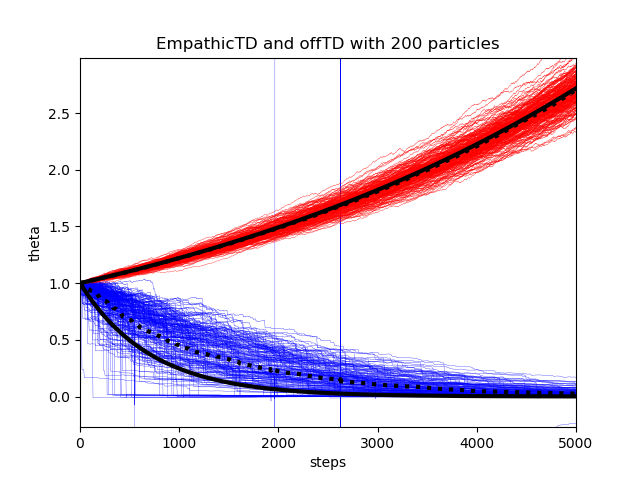

In [6]:
comparator.plot_theta()

## With other rewards

### Definition

In [7]:
model = Model(features = [[1,0], [0,1]],
              R = [[0, 3], [0, 10]],
              v_pi = [10/0.1, 10/0.1],
              pi = pi, mu = mu,
              I = [1, 1], discounts = [0.9, 0.9],
              lambdas = [0, 0],
              theta0 = 1,
              alpha = 0.001,
              S0 = 0)   

comparator = comparatorTD(model) # Useful class to compare offTD and empTD

### Running particles

In [8]:
T, N = 25000, 200
comparator.run(T, N)

empathic TD has been computed for 25000 steps and 200 particles.
offTD has been computed for 25000 steps and 200 particles.


### Theta estimates

<IPython.core.display.Javascript object>


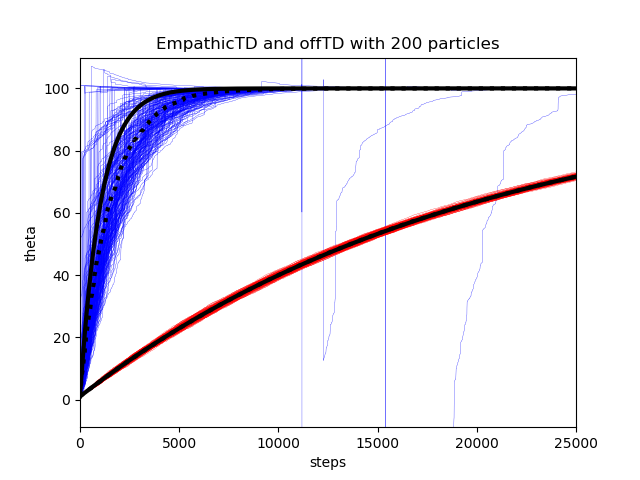

In [9]:
comparator.plot_theta(1)

### MSVE

<IPython.core.display.Javascript object>


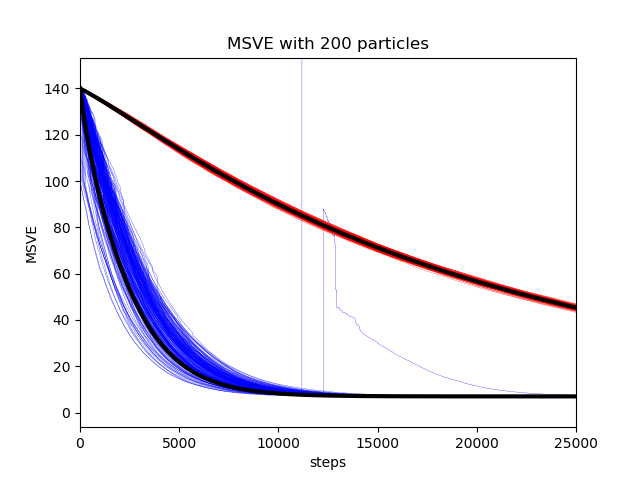

In [10]:
comparator.plot_msve()

## Bad behavior policy

In [11]:
pi = LeftRightPolicy(n = 2, p_right = 1)
mu = LeftRightPolicy(n = 2, p_right = 0.9)

model = Model(features = [[1,0], [0,1]],
              R = [[0, 3], [0, 10]],
              v_pi = [10/0.1, 10/0.1],
              pi = pi, mu = mu,
              I = [1, 1], discounts = [0.9, 0.9],
              lambdas = [0, 0],
              theta0 = 1,
              alpha = 0.001,
              S0 = 0) 

comparator = comparatorTD(model) # Useful class to compare offTD and empTD

### Running particles

In [12]:
comparator.run(25000, 50)

empathic TD has been computed for 25000 steps and 50 particles.
offTD has been computed for 25000 steps and 50 particles.


### Theta estimates

<IPython.core.display.Javascript object>


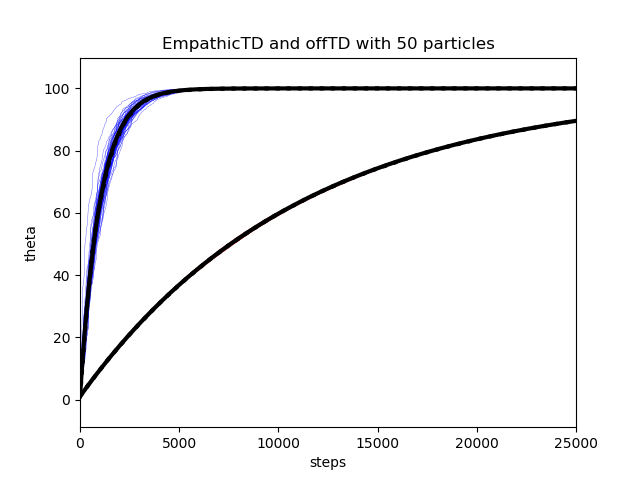

In [15]:
comparator.plot_theta(1)

###  MSVE

<IPython.core.display.Javascript object>


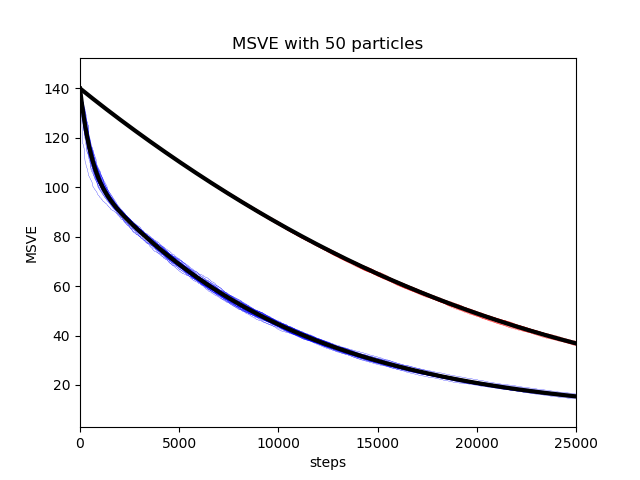

In [13]:
comparator.plot_msve()

# Five states model

In [4]:
#
# Modele with fives states (1, 2)
#

pi = LeftRightPolicy(n = 5, p_right = 1)

mu = LeftRightPolicy(n = 5, p_left = 2/3)

model = Model(features = [[1, 0, 0],
                          [1, 1, 0],
                          [0, 1, 0],
                          [0, 1, 1],
                          [0, 0, 1]],
              R = np.ones((5,5)),
              pi = pi, mu = mu,
              v_pi = [4, 3, 2, 1, 1],
              discounts = [0, 1, 1, 1, 0],
              lambdas = np.zeros(5),
              theta0 = 0, 
              alpha = 0.001,
              I = np.ones(5),
              S0 = 0)

comparator = comparatorTD(model) # Useful class to compare offTD and empTD

### Running particles

In [5]:
comparator.run(50000, 200)

empathic TD has been computed for 50000 steps and 200 particles.
offTD has been computed for 50000 steps and 200 particles.


### Theta estimates

<IPython.core.display.Javascript object>


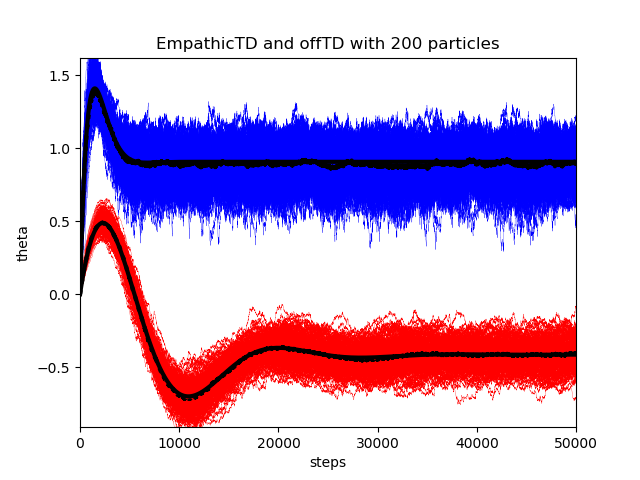

In [6]:
comparator.plot_theta(1)

### MSVE

<IPython.core.display.Javascript object>


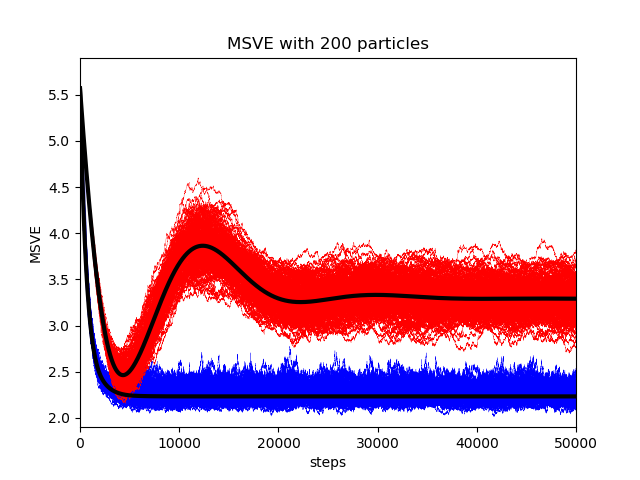

In [7]:
comparator.plot_msve()